# Project: Big Data - Comparing ec2 Instance Performances

## For Ray

In [1]:
#%pip install boto3

In [2]:
# Import Libraries
#!pip install ipywidgets
#!pip install wget

In [3]:
import ray
import os
import time
import numpy as np
import socket
import wget

In [4]:
import pandas as pd

In [5]:
import io

## Connect Ray

In [6]:
# Initialize ray client
ray.init(address="ray://172.31.31.167:10001")

Python version:,3.10.12
Ray version:,2.11.0
Dashboard:,http://127.0.0.1:8265


(pid=5588, ip=172.31.26.250) 2024-04-23 03:06:42.638179: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
(pid=5588, ip=172.31.26.250) 2024-04-23 03:06:42.644242: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
(pid=5587, ip=172.31.26.250) 2024-04-23 03:06:42.628198: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
(pid=5587, ip=172.31.26.250) 2024-04-23 03:06:42.633525: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
(pid=5588, ip=172.31.26.250) 2024-04-23 03:06:42.736205: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
(pid=5588, ip=172.31.26.250) To enable the following instructions: AVX2 AVX512F FMA, in othe

In [7]:
print('''This cluster consists of
    {} nodes with
    {} CPUs,
    {} GiB of aggregate memory capacity, and 
    an object store of {} GiB of memory.
    '''.format(len(ray.nodes()), ray.cluster_resources()['CPU'], 
           ray.cluster_resources()['memory'] / (1024*1024*1024), 
           ray.cluster_resources()['object_store_memory'] / (1024*1024*1024)))

This cluster consists of
    4 nodes with
    6.0 CPUs,
    14.34685249440372 GiB of aggregate memory capacity, and 
    an object store of 6.43891410715878 GiB of memory.
    


In [8]:
%%time

'''
(Optional testing code) 
Test your Ray cluster, see the outputs to check if all nodes are ready to work
the output should be like "123 tasks on 1.2.3.4".
By default, you have 5 nodes to execute remote tasks.
'''
import socket
from collections import Counter

@ray.remote
def f():
    time.sleep(0.001)
    # Return IP address.
    return socket.gethostbyname(socket.gethostname())

object_ids = [f.remote() for _ in range(1000)]
ip_addresses = ray.get(object_ids)

print('Tasks executed')
for ip_address, num_tasks in Counter(ip_addresses).items():
    print('    {} tasks on {}'.format(num_tasks, ip_address))

Tasks executed
    517 tasks on 172.31.26.250
    482 tasks on 172.31.26.225
    1 tasks on 172.31.31.167
CPU times: user 424 ms, sys: 96 ms, total: 520 ms
Wall time: 2.58 s


## Connect S3 data

In [9]:
import boto3

s3 = boto3.client('s3') # connect to s3

In [10]:
# response = s3.list_objects_v2(Bucket='digit-dataset') # connect to s3 bucket
@ray.remote
def process_data(data_bytes):
    # Convert bytes to DataFrame directly within the remote function
    df = pd.read_csv(io.BytesIO(data_bytes))
    return df.describe()
 
def load_data(bucket, key):
    # Initialize the S3 client locally
    s3 = boto3.client('s3')
    response = s3.get_object(Bucket=bucket, Key=key)
    data_bytes = response['Body'].read()
    return data_bytes
 
# Load data locally
data_bytes = load_data('ray-data-digit', 'digits.csv')
 
# Process data remotely
data_summary_id = process_data.remote(data_bytes)
data_summary = ray.get(data_summary_id)
print(data_summary)

       pixel_0_0    pixel_0_1    pixel_0_2    pixel_0_3    pixel_0_4  \
count     1797.0  1797.000000  1797.000000  1797.000000  1797.000000   
mean         0.0     0.303840     5.204786    11.835838    11.848080   
std          0.0     0.907192     4.754826     4.248842     4.287388   
min          0.0     0.000000     0.000000     0.000000     0.000000   
25%          0.0     0.000000     1.000000    10.000000    10.000000   
50%          0.0     0.000000     4.000000    13.000000    13.000000   
75%          0.0     0.000000     9.000000    15.000000    15.000000   
max          0.0     8.000000    16.000000    16.000000    16.000000   

         pixel_0_5    pixel_0_6    pixel_0_7    pixel_1_0    pixel_1_1  ...  \
count  1797.000000  1797.000000  1797.000000  1797.000000  1797.000000  ...   
mean      5.781859     1.362270     0.129661     0.005565     1.993879  ...   
std       5.666418     3.325775     1.037383     0.094222     3.196160  ...   
min       0.000000     0.000000    

In [11]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import sklearn
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import classification_report

In [12]:
df = pd.read_csv(io.BytesIO(data_bytes))

# Assume 'target' is the target column you want to predict
X = df.drop(columns=['target'])  # Assuming 'target' is the name of the target column
y = df['target']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optionally, you can print the sizes of train and test sets
print("Train set size:", len(X_train))
print("Test set size:", len(X_test))

Train set size: 1437
Test set size: 360


In [13]:
@ray.remote
def get_data(data):
    return data

# Distribute X_train, X_test, y_train, and y_test across Ray
X_train_id = get_data.remote(X_train)
X_test_id = get_data.remote(X_test)
y_train_id = get_data.remote(y_train)
y_test_id = get_data.remote(y_test)

# Retrieve the distributed data
X_train = ray.get(X_train_id)
X_test = ray.get(X_test_id)
y_train = ray.get(y_train_id)
y_test = ray.get(y_test_id)

## Using KNN for Classification

In [14]:
import ray
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

In [15]:
@ray.remote
def train_and_evaluate(X_train, X_test, y_train, y_test, k):
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    report = classification_report(y_test, y_pred)
    return knn.score(X_train, y_train), knn.score(X_test, y_test), report

In [16]:
%%time
# Run KNN with different values of k
k_val = range(1, 11)
train_accuracy = []
test_accuracy = []
reports = []

# Distribute the KNN training and evaluation tasks across Ray
for k in k_val:
    train_id = train_and_evaluate.remote(X_train, X_test, y_train, y_test, k)
    train_acc, test_acc, report = ray.get(train_id)
    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)
    reports.append(report)

/home/ubuntu/.local/lib/python3.10/site-packages/ray/util/client/worker.py:619: UserWarning: More than 10MB of messages have been created to schedule tasks on the server. This can be slow on Ray Client due to communication overhead over the network. If you're running many fine-grained tasks, consider running them inside a single remote function. See the section on "Too fine-grained tasks" in the Ray Design Patterns document for more details: https://docs.google.com/document/d/167rnnDFIVRhHhK4mznEIemOtj63IOhtIPvSYaPgI4Fg/edit#heading=h.f7ins22n6nyl. If your functions frequently use large objects, consider storing the objects remotely with ray.put. An example of this is shown in the "Closure capture of large / unserializable object" section of the Ray Design Patterns document, available here: https://docs.google.com/document/d/167rnnDFIVRhHhK4mznEIemOtj63IOhtIPvSYaPgI4Fg/edit#heading=h.1afmymq455wu
  warnings.warn(


CPU times: user 84 ms, sys: 23.2 ms, total: 107 ms
Wall time: 3.19 s


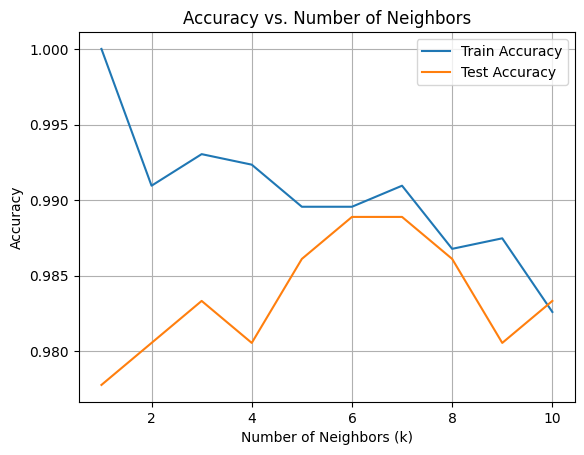

In [17]:
# Plot the accuracy scores
plt.plot(k_val, train_accuracy, label='Train Accuracy')
plt.plot(k_val, test_accuracy, label='Test Accuracy')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Neighbors')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
# Print the accuracy scores and classification reports for each k
for k_val, train_acc, test_acc, report in zip(k_val, train_accuracy, test_accuracy, reports):
    print(f'k={k_val}: Train Accuracy={train_acc:.2f}, Test Accuracy={test_acc:.2f}')
    print("Classification Report for k =", k_val)
    print(report)

k=1: Train Accuracy=1.00, Test Accuracy=0.98
Classification Report for k = 1
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       0.93      1.00      0.97        28
           2       1.00      1.00      1.00        33
           3       0.97      1.00      0.99        34
           4       0.98      0.98      0.98        46
           5       0.98      0.98      0.98        47
           6       0.97      1.00      0.99        35
           7       1.00      0.97      0.99        34
           8       1.00      0.93      0.97        30
           9       0.95      0.93      0.94        40

    accuracy                           0.98       360
   macro avg       0.98      0.98      0.98       360
weighted avg       0.98      0.98      0.98       360

k=2: Train Accuracy=0.99, Test Accuracy=0.98
Classification Report for k = 2
              precision    recall  f1-score   support

           0       1.00      1.0

## CNN

In [19]:
import numpy as np
import ray
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

2024-04-23 03:06:36.694066: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-23 03:06:36.698900: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-23 03:06:36.779925: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-23 03:06:38.008478: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [20]:
@ray.remote
class ModelTrainer:
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.model = self.create_model()

    def create_model(self):
        model = Sequential([
            Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(8, 8, 1)),
            MaxPooling2D(pool_size=(2, 2)),
            Flatten(),
            Dense(128, activation='relu'),
            Dense(10, activation='softmax')
        ])
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        return model

    def train(self, epochs=10, batch_size=10):
        history = self.model.fit(self.data, self.labels, epochs=epochs, batch_size=batch_size, verbose=0)
        return history.history

    def evaluate(self, test_data, test_labels):
        return self.model.evaluate(test_data, test_labels, verbose=0)

In [21]:
%%time
X_train_cnn = X_train.values.reshape(-1, 8, 8, 1).astype(np.float32)
X_val_cnn = X_test.values.reshape(-1, 8, 8, 1).astype(np.float32)

# Create Ray actors
trainers = [ModelTrainer.remote(X_train_cnn, y_train) for _ in range(4)]

# Train models in parallel
train_histories = ray.get([trainer.train.remote() for trainer in trainers])

# Evaluate models on the test set
test_results = ray.get([trainer.evaluate.remote(X_val_cnn, y_test) for trainer in trainers])


CPU times: user 190 ms, sys: 25.6 ms, total: 215 ms
Wall time: 25.7 s


In [22]:
for i, history in enumerate(train_histories):
    print(f"Trainer {i+1} - Training Loss: {history['loss'][-1]}, Accuracy: {history['accuracy'][-1]}")
for i, result in enumerate(test_results):
    print(f"Trainer {i+1} - Test performance: Loss = {result[0]}, Accuracy = {result[1]}")

Trainer 1 - Training Loss: 0.020719461143016815, Accuracy: 0.9944328665733337
Trainer 2 - Training Loss: 0.007180733606219292, Accuracy: 0.9993041157722473
Trainer 3 - Training Loss: 0.009556436911225319, Accuracy: 0.9993041157722473
Trainer 4 - Training Loss: 0.003879552474245429, Accuracy: 1.0
Trainer 1 - Test performance: Loss = 0.05673358589410782, Accuracy = 0.9750000238418579
Trainer 2 - Test performance: Loss = 0.054176945239305496, Accuracy = 0.9861111044883728
Trainer 3 - Test performance: Loss = 0.03818756341934204, Accuracy = 0.9777777791023254
Trainer 4 - Test performance: Loss = 0.047042619436979294, Accuracy = 0.9833333492279053


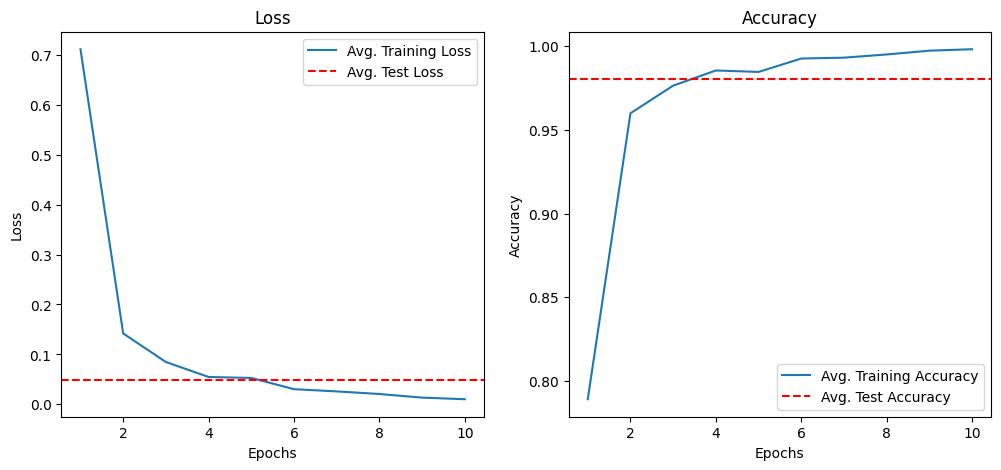

In [23]:
def plot_results(histories, results):
    epochs = range(1, len(histories[0]['loss']) + 1)
    avg_loss = np.mean([h['loss'] for h in histories], axis=0)
    avg_acc = np.mean([h['accuracy'] for h in histories], axis=0)
    avg_test_loss = np.mean([res[0] for res in results])
    avg_test_acc = np.mean([res[1] for res in results])

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, avg_loss, label='Avg. Training Loss')
    plt.axhline(y=avg_test_loss, color='r', linestyle='--', label='Avg. Test Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, avg_acc, label='Avg. Training Accuracy')
    plt.axhline(y=avg_test_acc, color='r', linestyle='--', label='Avg. Test Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Plot both training and test results
plot_results(train_histories, test_results)